<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Support Vector Machine para Detección de Phishing
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, 
                           confusion_matrix, matthews_corrcoef)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

print(f"Dataset shape: {df.shape}")
print(f"Distribución de clases:\n{df['CLASS_LABEL'].value_counts()}")

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

# División estratificada según metodología: 70% train, 15% val, 15% test

# Primera división: separar test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

# Segunda división: separar train (70%) y validation (15%) del restante 85%
# 15/85 = 0.176 para obtener 15% del total original
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_temp
)


Dataset shape: (10000, 49)
Distribución de clases:
CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64


In [5]:
def create_optuna_objective(X_train_scaled, y_train, cv_strategy=None):
    """
    Crea la función objetivo para Optuna, optimizando múltiples hiperparámetros del modelo SVM (SVC).
    
    Args:
        X_train_scaled: Características de entrenamiento escaladas
        y_train: Etiquetas de entrenamiento
        cv_strategy: Estrategia de validación cruzada (si no se pasa, se usa StratifiedKFold)
    
    Returns:
        function: Función objetivo para Optuna
    """
    
    if cv_strategy is None:
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    def objective(trial):
        # Sugerencia de hiperparámetros comunes
        C = trial.suggest_float('C', 0.1, 1000.0, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        shrinking = trial.suggest_categorical('shrinking', [True, False])
        class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

        # Parámetros base
        params = {
            'C': C,
            'kernel': kernel,
            'shrinking': shrinking,
            'class_weight': class_weight,
            'probability': True,
            'random_state': 42
        }

        # Parámetros según kernel
        if kernel in ['rbf', 'poly', 'sigmoid']:
            gamma_type = trial.suggest_categorical('gamma_type', ['scale_auto', 'numeric'])

            if gamma_type == 'scale_auto':
                gamma = trial.suggest_categorical('gamma_categorical', ['scale', 'auto'])
            else:
                gamma = trial.suggest_float('gamma_numeric', 0.001, 1.0, log=True)

            params['gamma'] = gamma

        if kernel == 'poly':
            degree = trial.suggest_int('degree', 2, 5)
            coef0 = trial.suggest_float('coef0', 0.0, 1.0)
            params['degree'] = degree
            params['coef0'] = coef0

        if kernel == 'sigmoid':
            coef0 = trial.suggest_float('coef0', 0.0, 1.0)
            params['coef0'] = coef0

        # Crear modelo y evaluar
        model = SVC(**params)

        cv_scores = cross_val_score(
            model, X_train_scaled, y_train,
            cv=cv_strategy, scoring='f1', n_jobs=-1
        )

        return cv_scores.mean()
    
    return objective

In [8]:
def evaluate_svm_model_optuna(X_train, X_val, X_test, y_train, y_val, y_test, 
                             n_trials=100, timeout=None):
    """
    Entrena y evalúa un modelo SVM con optimización de hiperparámetros usando Optuna
    
    Args:
        X_train, X_val, X_test: Conjuntos de características
        y_train, y_val, y_test: Etiquetas objetivo
        n_trials: Número de pruebas para Optuna
        timeout: Tiempo límite en segundos para la optimización
    
    Returns:
        dict: Resultados del modelo y métricas de evaluación
    """
    
    print("="*60)
    print("SUPPORT VECTOR MACHINE - DETECCIÓN DE PHISHING")
    print("OPTIMIZACIÓN CON OPTUNA")
    print("="*60)
    
    # Escalado de características (crítico para SVM)
    print("Escalando características...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Configuración de Optuna
    print(f"Iniciando optimización con Optuna...")
    print(f"Número de pruebas: {n_trials}")
    if timeout:
        print(f"Tiempo límite: {timeout} segundos")
    
    # Crear estudio de Optuna
    study = optuna.create_study(
        direction='maximize',  # Maximizar F1-score
        sampler=TPESampler(seed=42),
    )

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Crear función objetivo
    objective_func = create_optuna_objective(X_train_scaled, y_train, cv_strategy)
    
    # Optimización
    study.optimize(
        objective_func, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Mejor configuración encontrada
    best_params = study.best_params
    best_score = study.best_value
    
    print("\n" + "="*50)
    print("MEJORES HIPERPARÁMETROS ENCONTRADOS")
    print("="*50)
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Mejor F1-Score (CV): {best_score:.4f}")
    
    # Entrenar modelo final con mejores parámetros
    print("\nEntrenando modelo final...")
    
       # Preparar parámetros para el modelo final
    final_params = {
        'C': best_params['C'],
        'kernel': best_params['kernel'],
        'random_state': 42,
        'probability': True
    }
    
    # Extraer gamma correctamente
    if 'gamma_categorical' in best_params:
        final_params['gamma'] = best_params['gamma_categorical']
    elif 'gamma_numeric' in best_params:
        final_params['gamma'] = best_params['gamma_numeric']
    
    # Agregar degree si está presente (solo para kernel='poly')
    if 'degree' in best_params:
        final_params['degree'] = best_params['degree']
    
    # Agregar coef0 si está presente (para 'poly' y 'sigmoid')
    if 'coef0' in best_params:
        final_params['coef0'] = best_params['coef0']
    
    # Agregar shrinking si está presente
    if 'shrinking' in best_params:
        final_params['shrinking'] = best_params['shrinking']
    
    # Agregar class_weight si está presente
    if 'class_weight' in best_params:
        final_params['class_weight'] = best_params['class_weight']

    best_svm = SVC(**final_params)
    best_svm.fit(X_train_scaled, y_train)
    
    # Evaluación en conjunto de validación
    print("\n" + "="*50)
    print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
    print("="*50)
    
    y_val_pred = best_svm.predict(X_val_scaled)
    y_val_pred_proba = best_svm.predict_proba(X_val_scaled)[:, 1]
    
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'f1_score': f1_score(y_val, y_val_pred),
        'auc_roc': roc_auc_score(y_val, y_val_pred_proba),
        'specificity': recall_score(y_val, y_val_pred, pos_label=0),
        'mcc': matthews_corrcoef(y_val, y_val_pred)
    }
    
    print("Métricas en Validación:")
    for metric, value in val_metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    # Verificación de criterios de selección
    print(f"\n✓ Criterios de selección:")
    print(f"  - F1-Score: {val_metrics['f1_score']:.4f}")
    print(f"  - AUC-ROC ≥ 0.90: {'✓' if val_metrics['auc_roc'] >= 0.90 else '✗'} ({val_metrics['auc_roc']:.4f})")
    
    # Evaluación final en conjunto de prueba
    print("\n" + "="*50)
    print("EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA")
    print("="*50)
    
    y_test_pred = best_svm.predict(X_test_scaled)
    y_test_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1_score': f1_score(y_test, y_test_pred),
        'auc_roc': roc_auc_score(y_test, y_test_pred_proba),
        'specificity': recall_score(y_test, y_test_pred, pos_label=0),
        'mcc': matthews_corrcoef(y_test, y_test_pred)
    }
    
    print("Métricas en Prueba:")
    for metric, value in test_metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Análisis de la optimización con Optuna
    print("\n" + "="*50)
    print("ANÁLISIS DE LA OPTIMIZACIÓN")
    print("="*50)
    print(f"Número total de pruebas: {len(study.trials)}")
    print(f"Número de pruebas completadas: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    print(f"Mejor valor encontrado: {study.best_value:.4f}")
    
    # Visualización de resultados
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Matriz de Confusión - Conjunto de Prueba')
    axes[0,0].set_xlabel('Predicción')
    axes[0,0].set_ylabel('Valor Real')
    
    # Comparación de métricas entre validación y prueba
    metrics_comparison = pd.DataFrame({
        'Validación': val_metrics,
        'Prueba': test_metrics
    })
    
    metrics_comparison.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Comparación Métricas: Validación vs Prueba')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend()
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Historia de optimización
    trial_values = [trial.value for trial in study.trials if trial.value is not None]
    axes[0,2].plot(trial_values)
    axes[0,2].axhline(y=study.best_value, color='red', linestyle='--', 
                     label=f'Mejor: {study.best_value:.4f}')
    axes[0,2].set_title('Historia de Optimización Optuna')
    axes[0,2].set_xlabel('Prueba')
    axes[0,2].set_ylabel('F1-Score')
    axes[0,2].legend()
    
    # Distribución de probabilidades
    axes[1,0].hist(y_test_pred_proba[y_test==0], alpha=0.7, label='Legítimo', bins=30)
    axes[1,0].hist(y_test_pred_proba[y_test==1], alpha=0.7, label='Phishing', bins=30)
    axes[1,0].set_title('Distribución de Probabilidades Predichas')
    axes[1,0].set_xlabel('Probabilidad de Phishing')
    axes[1,0].set_ylabel('Frecuencia')
    axes[1,0].legend()
    
    # Importancia de hiperparámetros (si hay suficientes pruebas)
    if len(study.trials) > 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            param_names = list(importance.keys())
            importance_values = list(importance.values())
            
            axes[1,1].barh(param_names, importance_values)
            axes[1,1].set_title('Importancia de Hiperparámetros')
            axes[1,1].set_xlabel('Importancia')
        except:
            axes[1,1].text(0.5, 0.5, 'No se pudo calcular\nla importancia', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Importancia de Hiperparámetros')
    
    # Distribución de mejores valores por kernel
    kernel_trials = {}
    for trial in study.trials:
        if trial.value is not None and 'kernel' in trial.params:
            kernel = trial.params['kernel']
            if kernel not in kernel_trials:
                kernel_trials[kernel] = []
            kernel_trials[kernel].append(trial.value)
    
    if kernel_trials:
        axes[1,2].boxplot(kernel_trials.values(), labels=kernel_trials.keys())
        axes[1,2].set_title('Distribución F1-Score por Kernel')
        axes[1,2].set_ylabel('F1-Score')
        axes[1,2].set_xlabel('Kernel')
    
    plt.tight_layout()
    plt.show()
    
    # Reporte detallado de clasificación
    print("\n" + "="*50)
    print("REPORTE DETALLADO DE CLASIFICACIÓN")
    print("="*50)
    print(classification_report(y_test, y_test_pred, 
                              target_names=['Legítimo', 'Phishing']))
    
    # Validación cruzada final con mejores parámetros
    final_cv_scores = cross_val_score(
        best_svm, X_train_scaled, y_train, 
        cv=cv_strategy, scoring='f1', n_jobs=-1
    )
    
    cv_std = np.std(final_cv_scores)
    print(f"\nEstabilidad en CV (Desviación Estándar): {cv_std:.4f}")
    print(f"Coeficiente de Variación: {cv_std/np.mean(final_cv_scores):.4f}")
    
    return {
        'model': best_svm,
        'scaler': scaler,
        'best_params': best_params,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'cv_scores': final_cv_scores,
        'optuna_study': study,
        'optimization_history': trial_values
    }

[I 2025-06-12 22:42:14,972] A new study created in memory with name: no-name-e362f0d7-6c57-4136-a34d-b4be91aafa56


SUPPORT VECTOR MACHINE - DETECCIÓN DE PHISHING
OPTIMIZACIÓN CON OPTUNA
Escalando características...
Iniciando optimización con Optuna...
Número de pruebas: 20
Tiempo límite: 1800 segundos


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-12 22:42:25,536] Trial 0 finished with value: 0.943840521256682 and parameters: {'C': 3.14891164795686, 'kernel': 'linear', 'shrinking': True, 'class_weight': None}. Best is trial 0 with value: 0.943840521256682.
[I 2025-06-12 22:42:31,455] Trial 1 finished with value: 0.9692472732842969 and parameters: {'C': 67.96578090758145, 'kernel': 'rbf', 'shrinking': False, 'class_weight': 'balanced', 'gamma_type': 'scale_auto', 'gamma_categorical': 'scale'}. Best is trial 1 with value: 0.9692472732842969.
[I 2025-06-12 22:42:38,681] Trial 2 finished with value: 0.9584159632021965 and parameters: {'C': 1.4742753159914666, 'kernel': 'poly', 'shrinking': False, 'class_weight': 'balanced', 'gamma_type': 'scale_auto', 'gamma_categorical': 'auto', 'degree': 5, 'coef0': 0.3046137691733707}. Best is trial 1 with value: 0.9692472732842969.
[I 2025-06-12 22:42:46,928] Trial 3 finished with value: 0.9416423352654444 and parameters: {'C': 0.24586032763280052, 'kernel': 'linear', 'shrinking': Fal

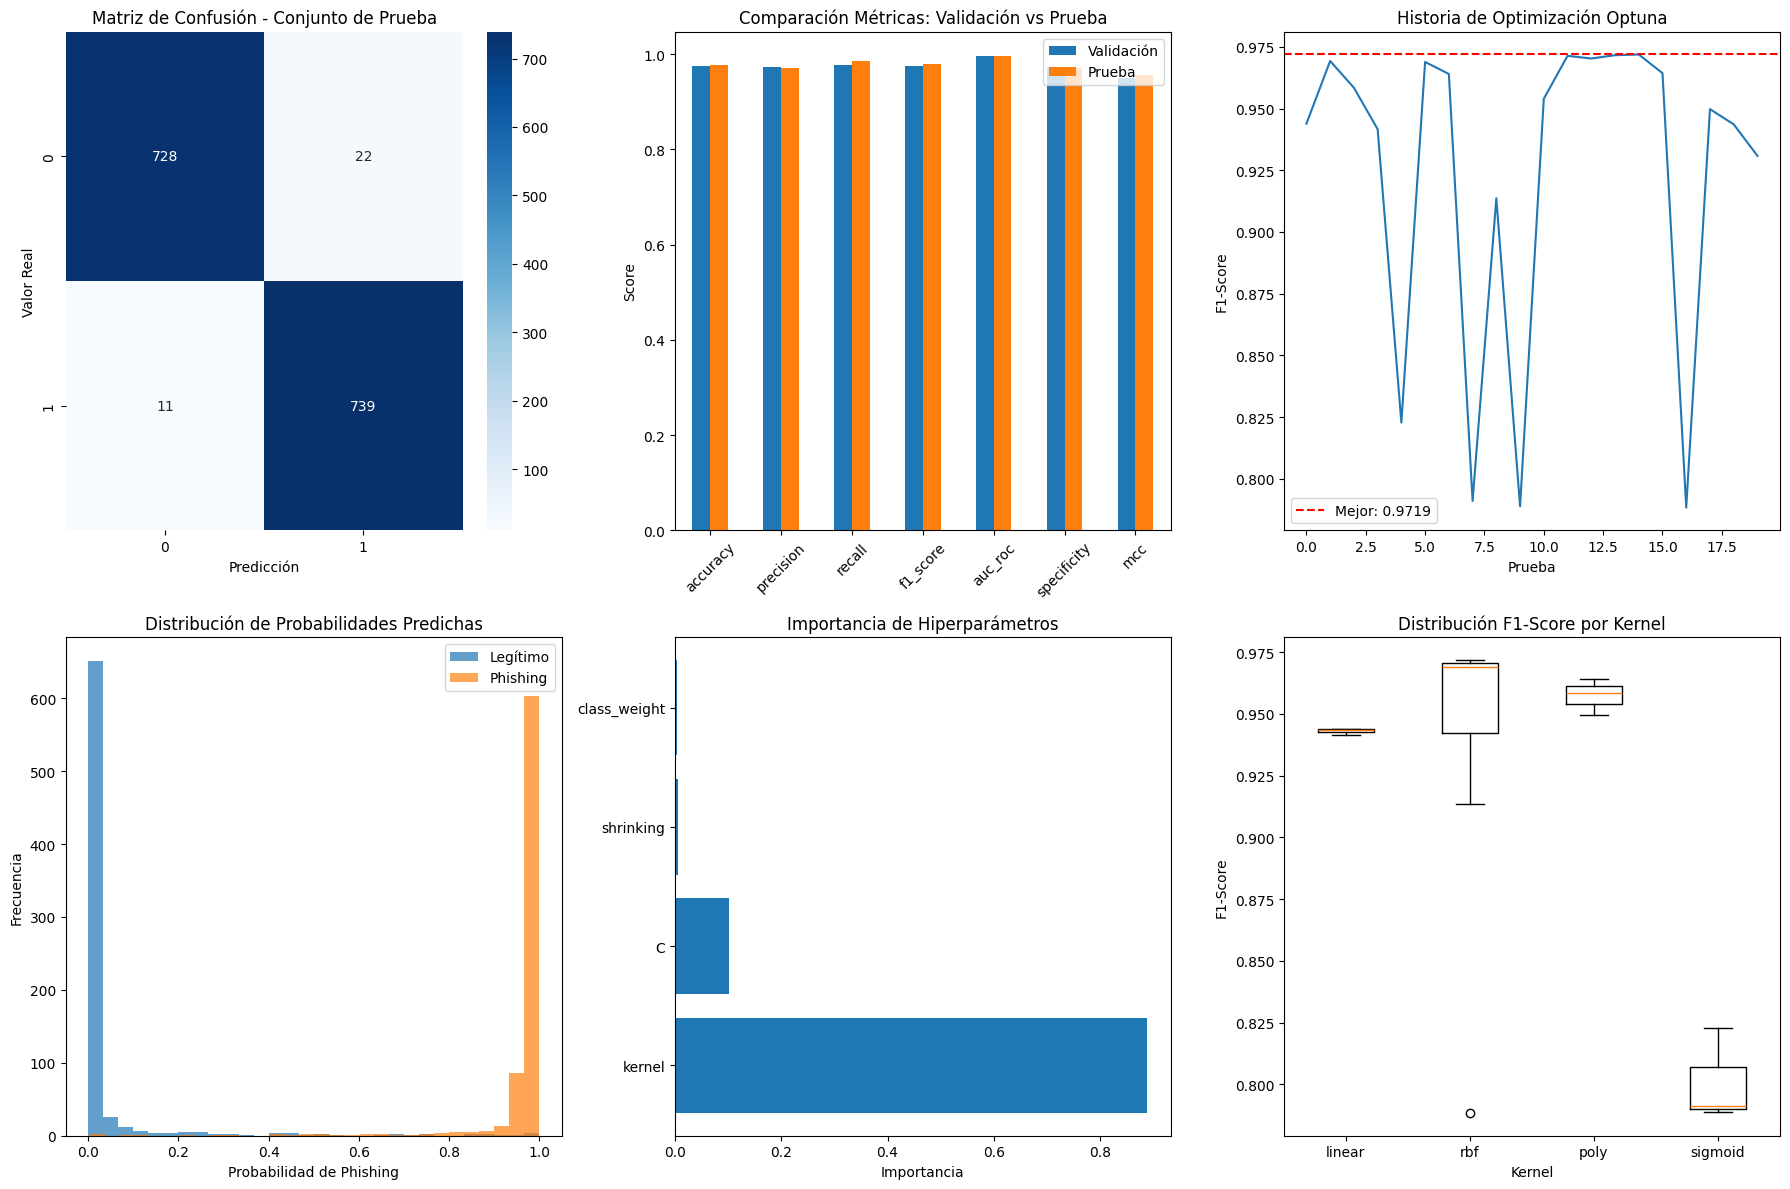


REPORTE DETALLADO DE CLASIFICACIÓN
              precision    recall  f1-score   support

    Legítimo       0.99      0.97      0.98       750
    Phishing       0.97      0.99      0.98       750

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500


Estabilidad en CV (Desviación Estándar): 0.0042
Coeficiente de Variación: 0.0043
Modelo final - F1 en validación: 0.9753
Modelo final - F1 en prueba: 0.9782

Análisis adicional de la optimización:
Mejor valor: 0.9719
Número total de pruebas: 20


In [9]:
results_svm = evaluate_svm_model_optuna(
    X_train, X_val, X_test, y_train, y_val, y_test,
    n_trials=20,  # Número de pruebas (ajusta según tu tiempo disponible)
    timeout=1800   # 1 hora límite (opcional)
)

# Acceso a los resultados
best_model = results_svm['model']
validation_f1 = results_svm['val_metrics']['f1_score']
test_f1 = results_svm['test_metrics']['f1_score']
study = results_svm['optuna_study']

print(f"Modelo final - F1 en validación: {validation_f1:.4f}")
print(f"Modelo final - F1 en prueba: {test_f1:.4f}")

# Análisis adicional de Optuna
print("\nAnálisis adicional de la optimización:")
print(f"Mejor valor: {study.best_value:.4f}")
print(f"Número total de pruebas: {len(study.trials)}")


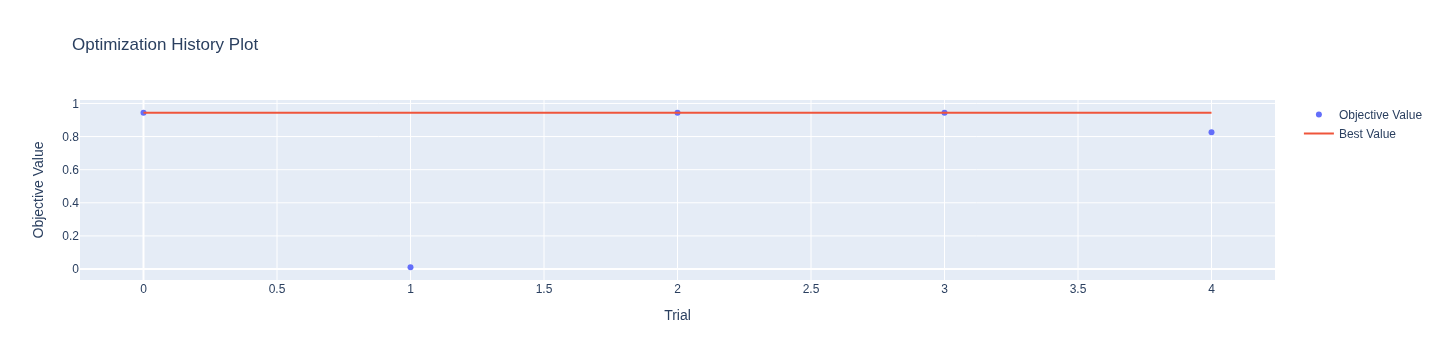

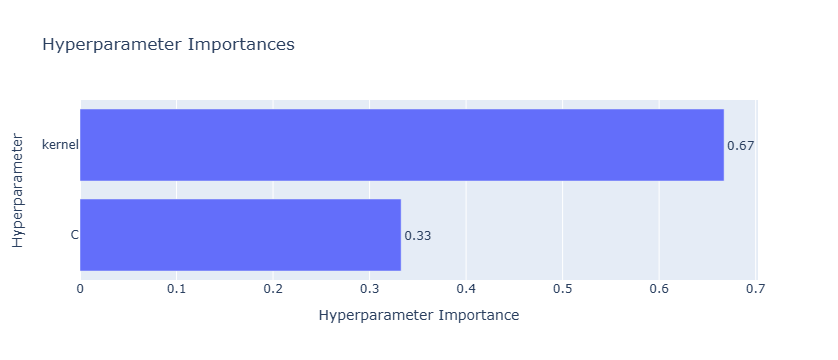

In [13]:

# Visualizar la optimización 
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()